<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

## Описание проекта

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от **0 до 1**, где **0 — совершенно неудовлетворён, 1 — полностью удовлетворён**. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
- **Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- **Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">
    
## Задача 1: предсказание уровня удовлетворённости сотрудника

### Данные

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.


### Содержание работы
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ
4. Подготовка данных
5. Обучение модели
6. Вывод


### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler,RobustScaler, Normalizer, OrdinalEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind
from sklearn.model_selection import RandomizedSearchCV
import phik

import warnings

from sklearn.dummy import DummyRegressor, DummyClassifier

import shap
from sklearn.metrics import make_scorer, roc_auc_score
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (12,12)

C:\Users\Alexander\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
try:
    train = pd.read_csv('train_job_satisfaction_rate.csv')
    test = pd.read_csv('test_features.csv')
    test_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test = pd.read_csv('/datasets/test_features.csv')
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
pd.set_option('display.max_columns', None)

### Предобработка данных

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [7]:
train.duplicated().sum()

0

В задаче присутствуют пропущенные данные.Рассмотрим уникальные значения категориальных переменных

In [8]:
for cl in train.select_dtypes(include='object').columns:
    print(f"{cl} : {train[cl].unique()}")

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


### Вывод по предобработка данных

Предобработка данных показала, что в данных отстуствуют явные и неявные дубликаты. Также присутствует небольшое количество пропусков

### Исследовательский анализ

In [9]:
dictionary = {
    'dept': 'Отдел', 
    'level': 'Уровень занимаемой должности', 
    'workload': 'Загруженность работника', 
    'employment_years': 'Трудовой стаж',
    'last_year_promo': 'Повышение за последний год', 
    'last_year_violations': 'Нарушение трудового договора за последний год', 
    'supervisor_evaluation': 'Оценка качества работы сотрудника',
    'salary': 'Зарплата', 
    'job_satisfaction_rate': 'Удовлетворенность работой',
    'quit': 'Увольнение сотрудника из компании'
}

In [10]:
def plt_num(data):
    num = data.drop('id', axis=1).select_dtypes(exclude='object')
    a = 5
    b = 3
    c = 1
    for col in num.columns:
        plt.subplot(a,b,c)
        sns.histplot(x = num[col], kde=True)
        plt.xlabel(f'{dictionary[col]}')
        plt.ylabel(f'Количество')
        plt.title(f'{dictionary[col]}')
        c += 1
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

In [11]:
def plt_cat(data):
    cat = data.select_dtypes(include='object')
    plt.rc('xtick', labelsize= 10) 
    a = 3
    b = 2
    c = 1
    for col in cat.columns:
        plt.subplot(a,b,c)
        sns.countplot(data =cat, x = col, order=cat[col].value_counts(ascending=True).index)
        plt.xlabel(f'{dictionary[col]}')
        plt.ylabel('Количество')
        plt.title(f'{dictionary[col]}')
        
        c += 1
    plt.tight_layout()
    plt.show()

In [12]:
def plt_num_boxplot(data):
    num = data.drop('id', axis=1).select_dtypes(exclude='object')
    a = 5
    b = 3
    c = 1
    for col in num.columns:
        plt.subplot(a,b,c)
        sns.boxplot(x = num[col])
        plt.xlabel(f'{dictionary[col]}')
        plt.title(f'{dictionary[col]}')
        c += 1


    plt.tight_layout()
    plt.show()

In [13]:
def vif(X,num_col, cat_col):
    """
    На входе X - признаки,
             num_col - список количественных признаков
             cat_col - список категориальны признаков 
    На выходе получаем датафрейм с коэффициентами мультиколлениарности
    
    """
    
    ohe = OneHotEncoder(drop='first', sparse=False)
    scaler = StandardScaler()

    if len(num_col) == 0:
         X_ohe = ohe.fit_transform(X[cat_col])
         X = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
    else:
        X_ohe = ohe.fit_transform(X[cat_col])
        X_num = scaler.fit_transform(X[num_col])
        X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        X_num = pd.DataFrame(X_num, columns=num_col)
        X = pd.concat([X_num, X_ohe], axis=1)
# Вычисление VIF
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

    # Вывод VIF
    return vif

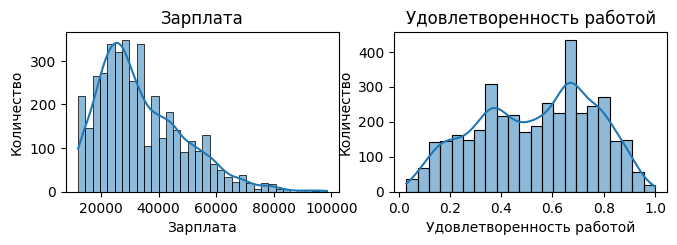

In [14]:
plt_num(train[['id','salary', 'job_satisfaction_rate']])

Зарплата сотрудников имеет длинный правый хвост, а уровень удовлетворенности работой имеет два выраженных пика

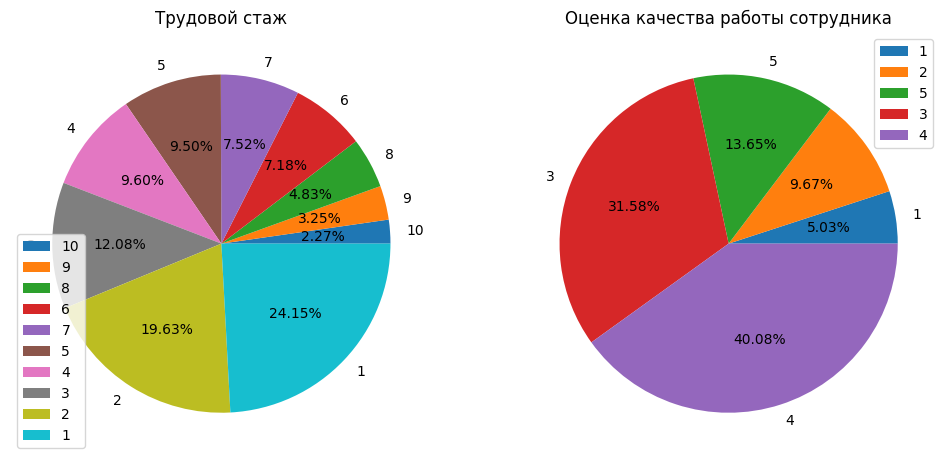

In [15]:
c = 1
for cl in ['employment_years', 'supervisor_evaluation']:
    plt.subplot(1,2,c)
    plt.pie(train[cl].value_counts().sort_values(), autopct='%.2f%%', labels=train[cl].value_counts().sort_values().index)
    plt.title(f'{dictionary[cl]}')
    plt.legend()
    c += 1
    

plt.show()

В компании почти половина сотрудников работает до двух лет в этой компании. Оценка работника руководителем в основном 3 либо 4

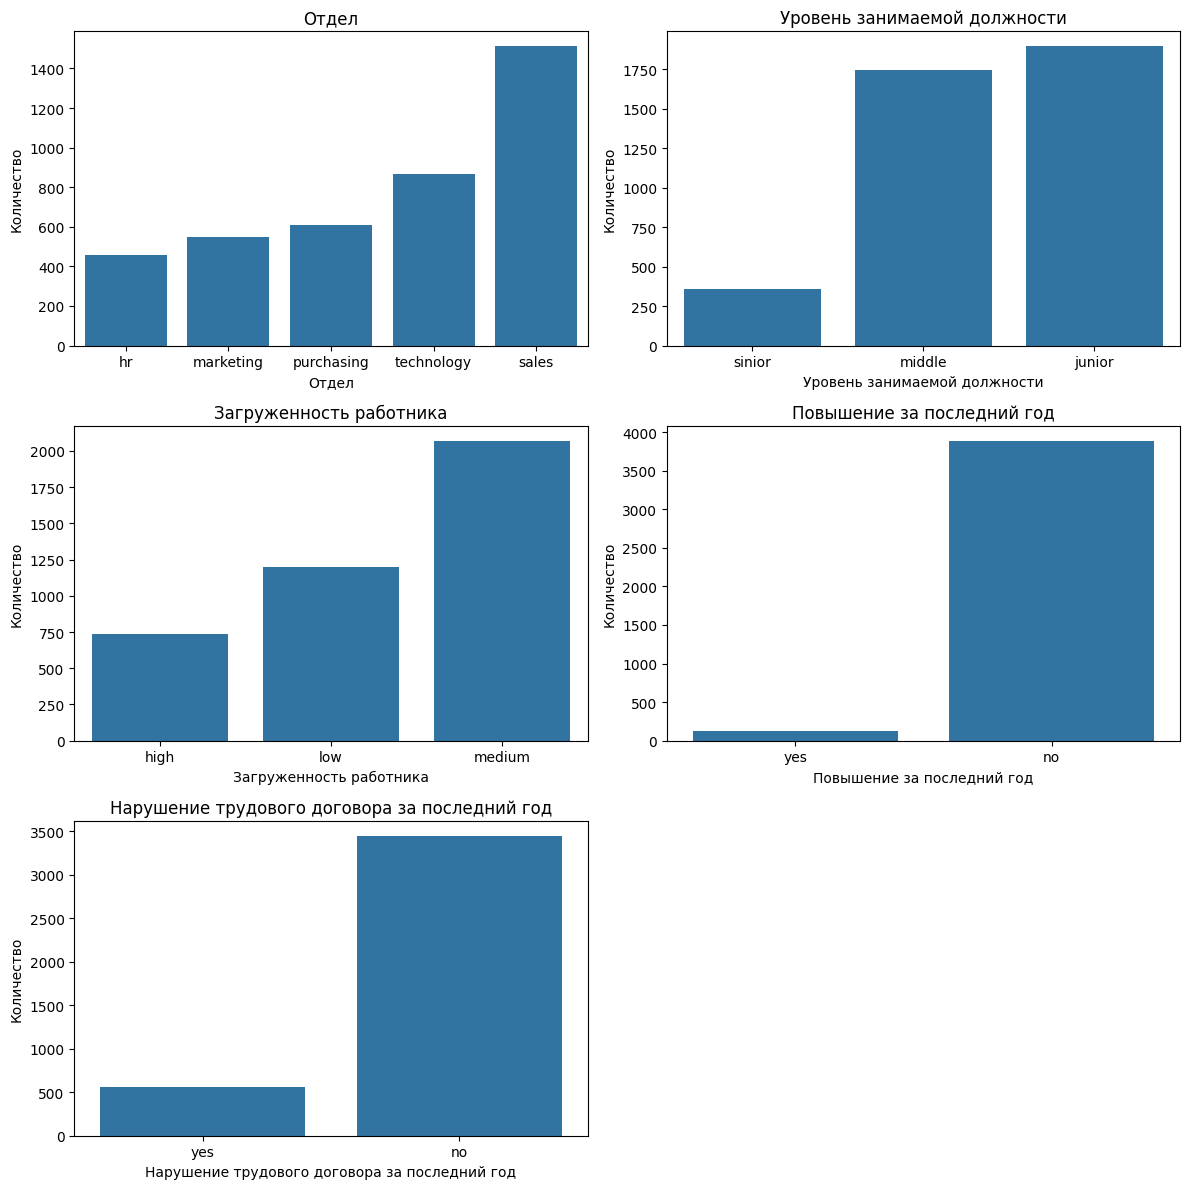

In [16]:
plt_cat(train)

В компании больше всего работают в продажах, уровня middle, junior, со средним уровнем загруженности, без повышения в зарплате за последний год, без нарушений

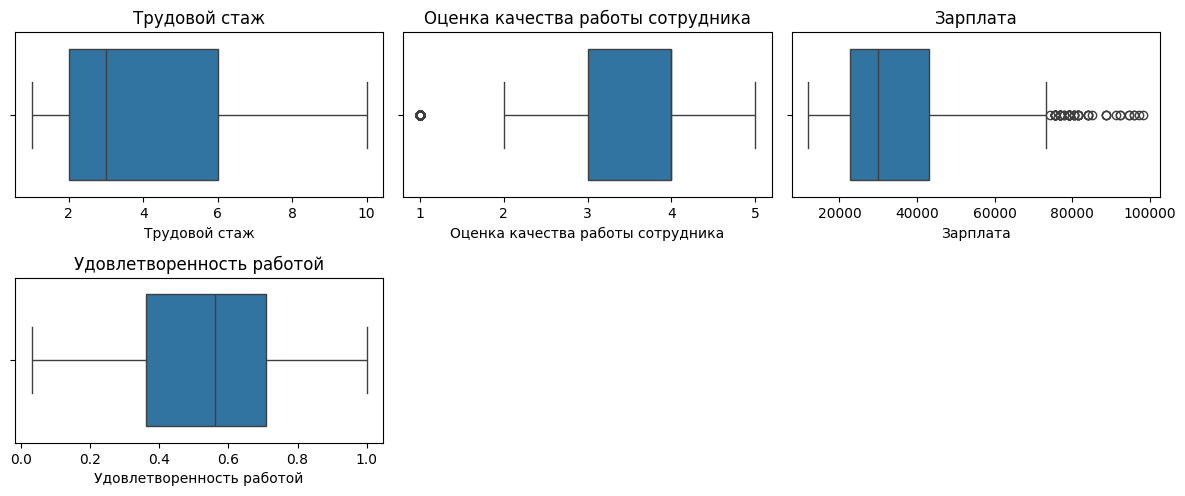

In [17]:
plt_num_boxplot(train)

Больше 70000 зарплата является нетепичным значением

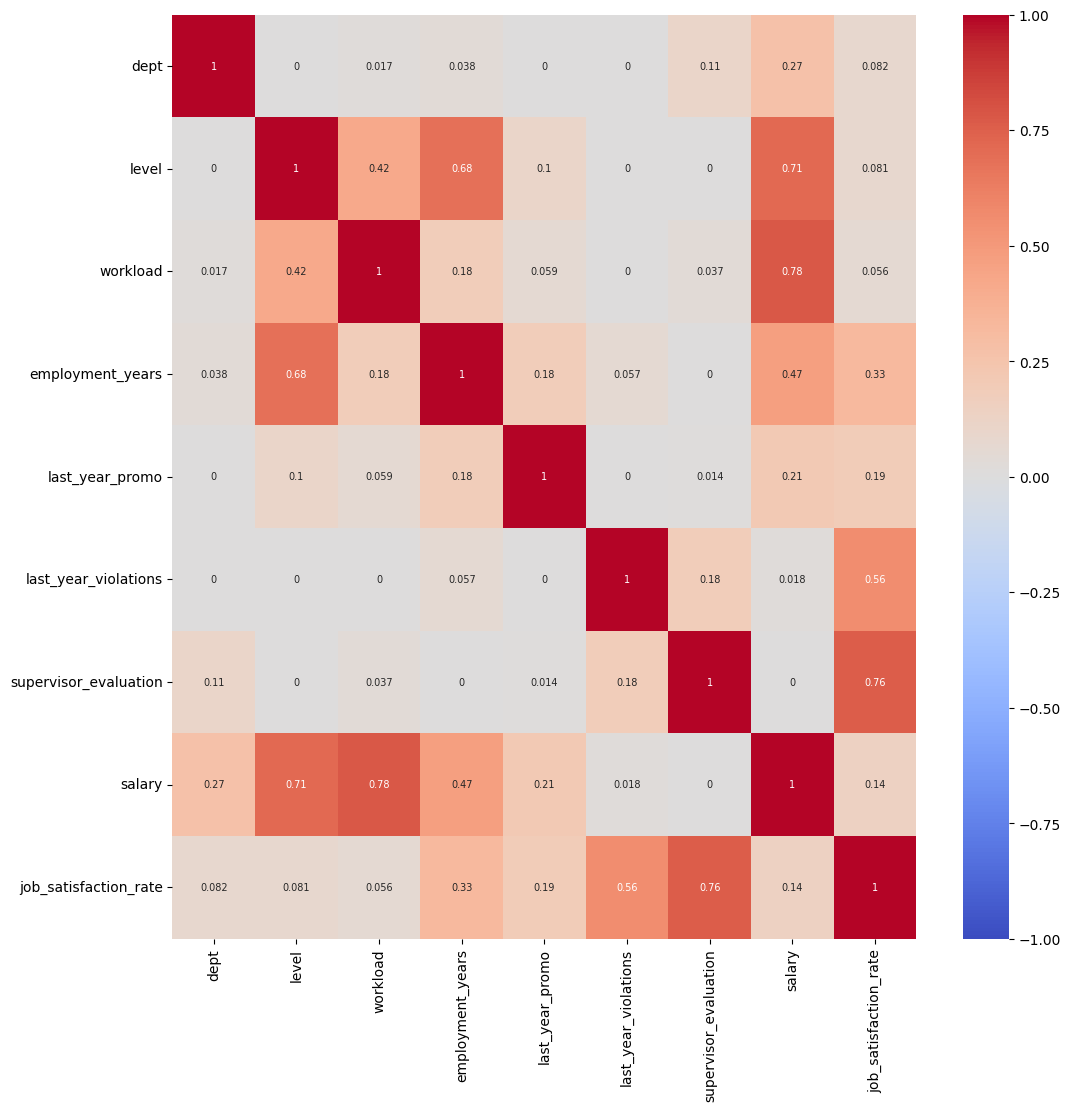

In [18]:
num_cols = ['salary', 'job_satisfaction_rate']
sns.heatmap(phik.phik_matrix(train.drop('id', axis=1), interval_cols=num_cols),annot=True, annot_kws={'size':7},\
            vmax=1, vmin=-1, cmap='coolwarm', center=0);

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [20]:
X = train.drop('id', axis=1)
num_col = X[['salary', 'job_satisfaction_rate']].columns
cat_col = X.drop(num_col, axis=1).columns
vif(X, num_col, cat_col)

,Features,VIF
0,salary,12.144968
1,job_satisfaction_rate,4.900398
2,dept_marketing,2.089392
3,dept_purchasing,2.060454
4,dept_sales,3.744528
5,dept_technology,3.308426
6,dept_nan,1.018520
7,level_middle,9.841123
8,level_sinior,6.747341
9,level_nan,1.007533


Проверим тренировочную выборку на дубликаты после удаления столбца `id`

In [21]:
X.duplicated().sum()

245

Удалим явные дубликаты и занаово пересчитаем VIF

In [22]:
X = X.drop_duplicates().reset_index(drop=True)

In [23]:
num_col = X[['salary', 'job_satisfaction_rate']].columns
cat_col = X.drop(num_col, axis=1).columns
vif(X, num_col, cat_col)

,Features,VIF
0,salary,12.227689
1,job_satisfaction_rate,4.902046
2,dept_marketing,2.087440
3,dept_purchasing,2.056264
4,dept_sales,3.578892
5,dept_technology,3.276051
6,dept_nan,1.019412
7,level_middle,10.043571
8,level_sinior,7.022049
9,level_nan,1.008413


Удалим `workload`, `salary`

In [24]:
X = X.drop(['workload', 'salary'], axis=1)

In [25]:
num_col = ['job_satisfaction_rate']
cat_col = X.drop(num_col, axis=1).columns
vif(X, num_col, cat_col)

,Features,VIF
0,job_satisfaction_rate,4.022318
1,dept_marketing,1.953430
2,dept_purchasing,2.008306
3,dept_sales,3.509365
4,dept_technology,2.489911
5,dept_nan,1.019361
6,level_middle,4.270405
7,level_sinior,1.963372
8,level_nan,1.007604
9,employment_years_2,1.868302


Удалив столбец `workload`,`salary` мы избавились от мультиколлинеарности

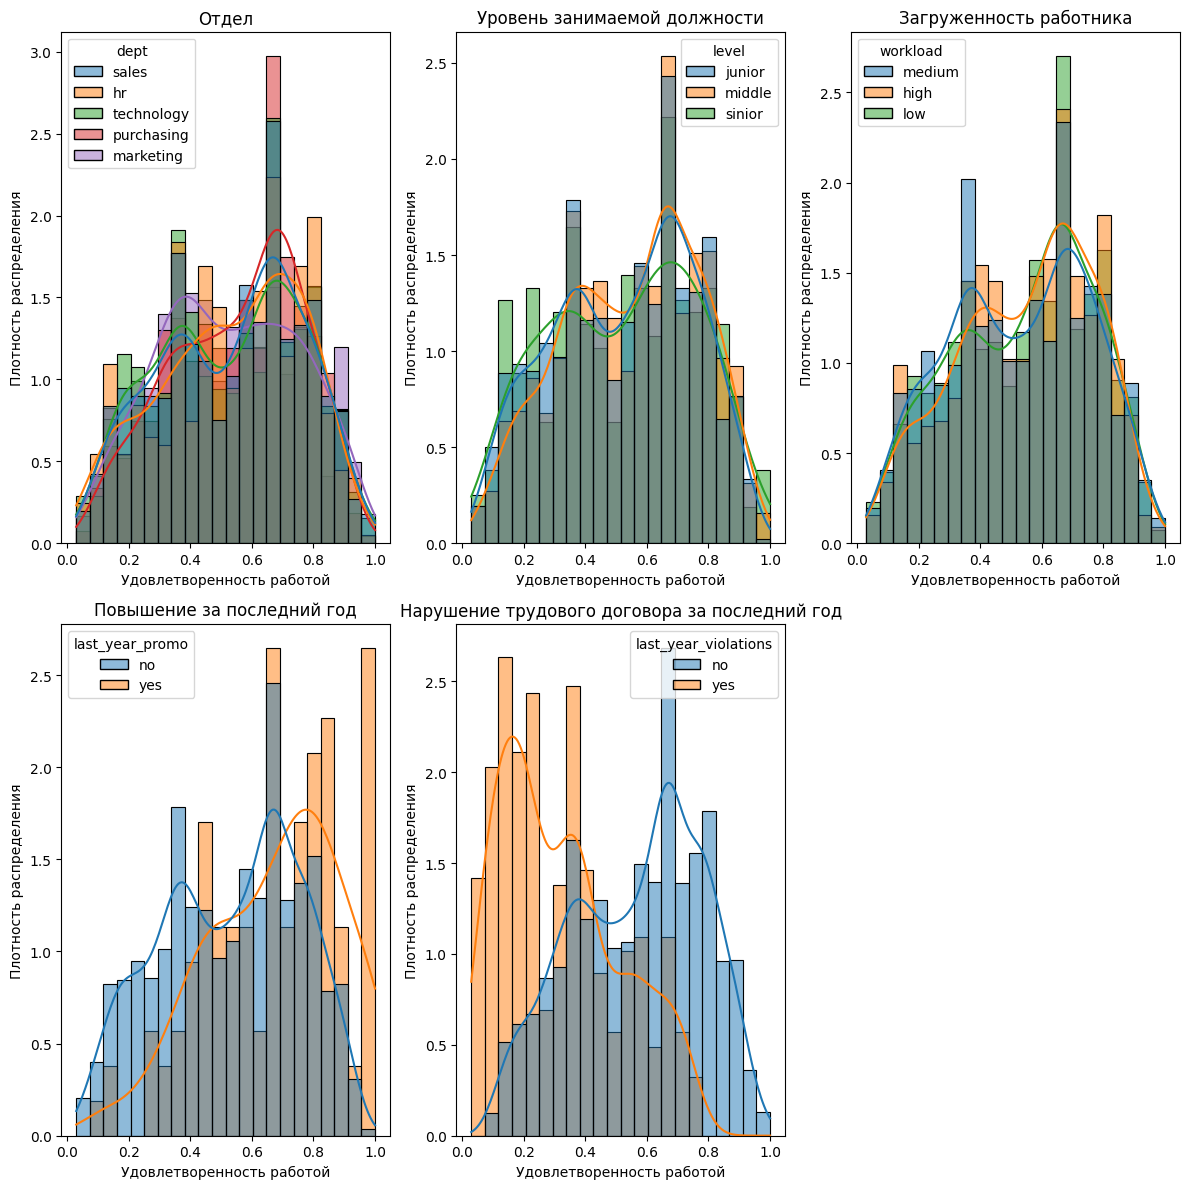

In [26]:
c = 1
for cl in train.select_dtypes(include='object'):
    plt.subplot(2,3,c)
    sns.histplot(data=train, x='job_satisfaction_rate', hue=cl, kde=True, stat='density', common_norm=False)
    plt.title(f'{dictionary[cl]}')
    plt.xlabel(f'{dictionary["job_satisfaction_rate"]}')
    plt.ylabel('Плотность распределения')
    c+=1

plt.tight_layout()
plt.show()

Примечательный график зависимости `job_satisfaction_rate` от `last_year_violations`. Работники у которых за последний год были нарушения имеют медианное значение намного ниже, чем те кто не совершал.

Проведем исследовательский анализ для тестовой выборки

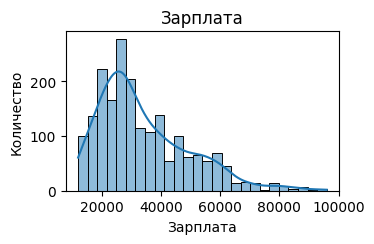

In [27]:
plt_num(test[['id','salary']])

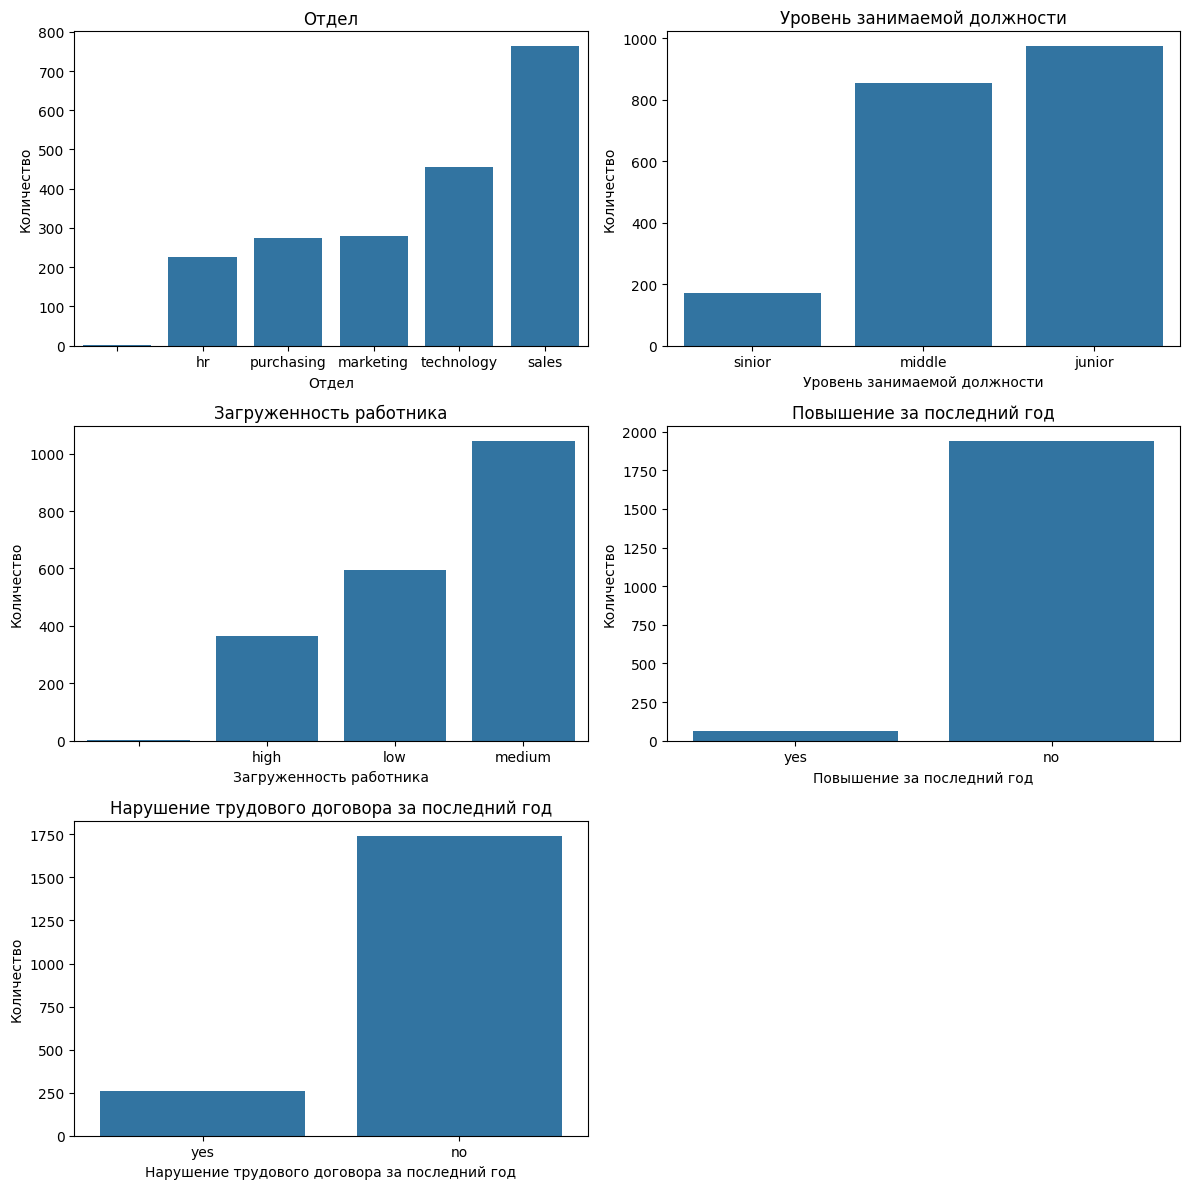

In [28]:
plt_cat(test)

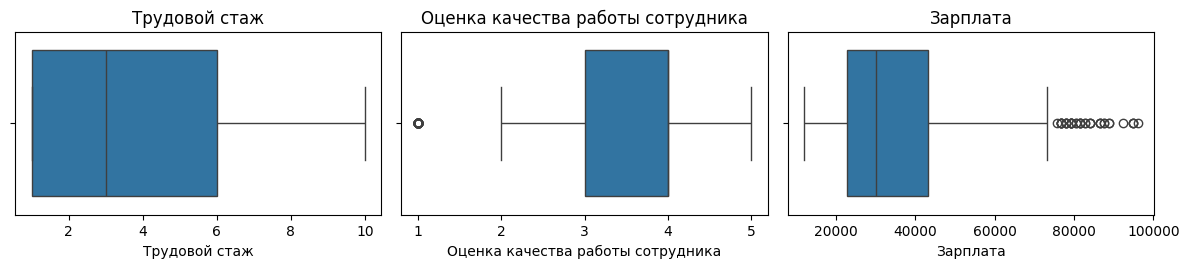

In [29]:
plt_num_boxplot(test)

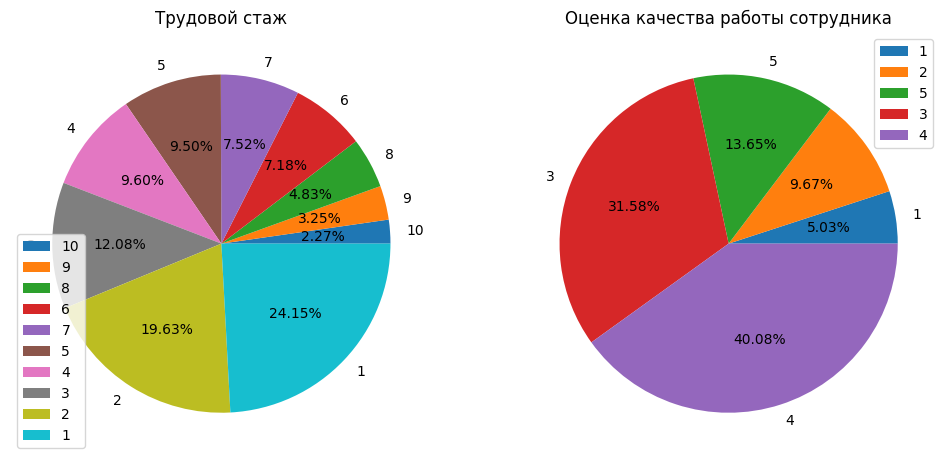

In [30]:
c = 1
for cl in ['employment_years', 'supervisor_evaluation']:
    plt.subplot(1,2,c)
    plt.pie(train[cl].value_counts().sort_values(), autopct='%.2f%%', labels=train[cl].value_counts().sort_values().index)
    plt.title(f'{dictionary[cl]}')
    plt.legend()
    c += 1
    

plt.show()

Проведем корреляционный анализ для тестовой выборки

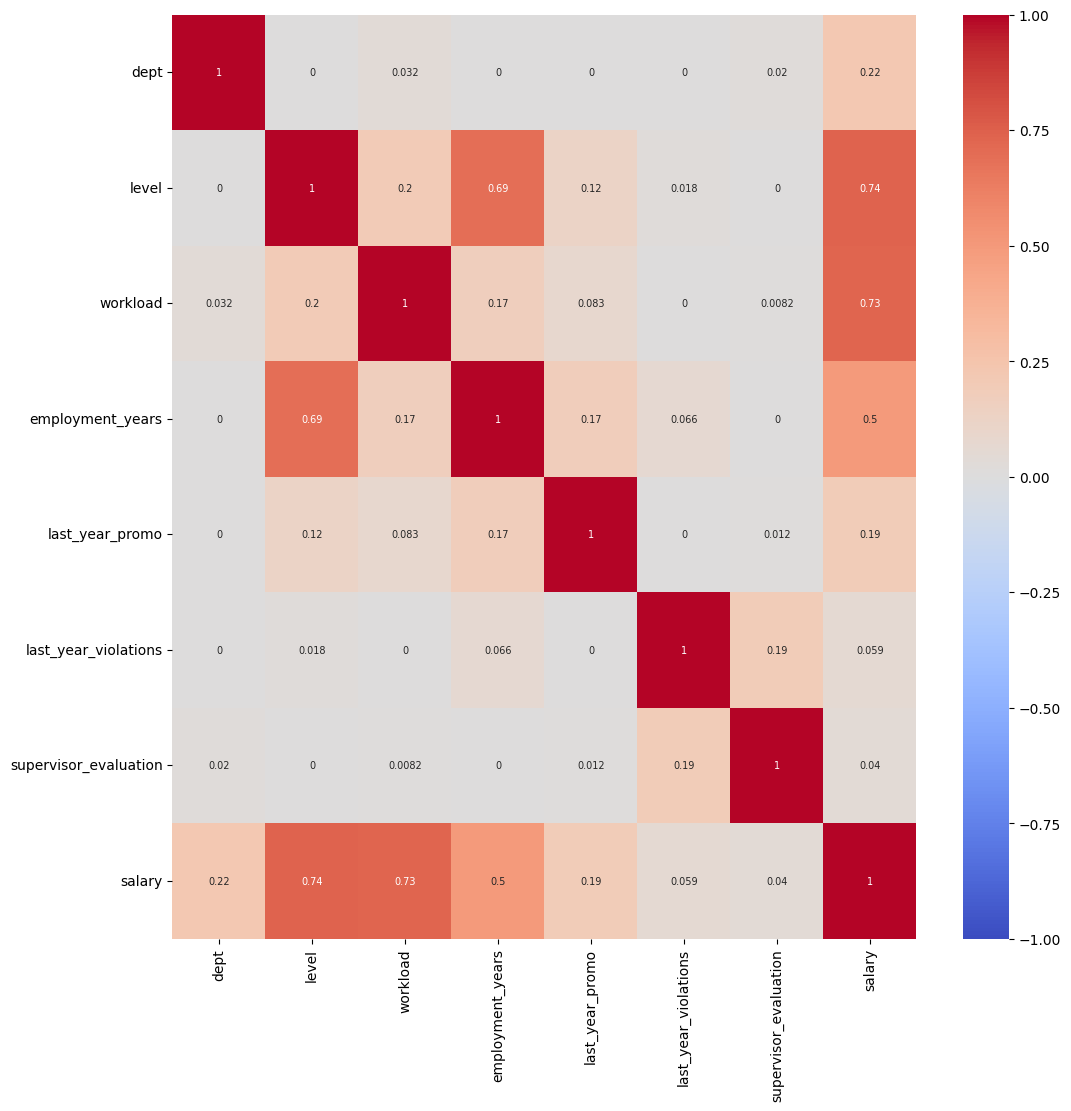

In [31]:
num_cols = ['salary']
sns.heatmap(phik.phik_matrix(test.drop('id', axis=1), interval_cols=num_cols),annot=True, annot_kws={'size':7},\
            vmax=1, vmin=-1, cmap='coolwarm', center=0);

In [32]:
num_col = ['salary']
cat_col = test.drop(['id', 'salary'], axis=1).columns
vif(test, num_col, cat_col)

,Features,VIF
0,salary,12.189371
1,dept_hr,116.376101
2,dept_marketing,141.766001
3,dept_purchasing,139.851472
4,dept_sales,389.438585
5,dept_technology,232.290439
6,dept_nan,2.012848
7,level_middle,7.668502
8,level_sinior,5.951276
9,level_nan,1.005457


In [33]:
num_col = []
cat_col = test.drop(['id', 'dept', 'salary', 'workload'], axis=1).columns
vif(test, num_col, cat_col)

,Features,VIF
0,level_middle,3.908694
1,level_sinior,1.833807
2,level_nan,1.003121
3,employment_years_2,1.642118
4,employment_years_3,1.556037
5,employment_years_4,1.525500
6,employment_years_5,1.789083
7,employment_years_6,1.717322
8,employment_years_7,1.923595
9,employment_years_8,1.483426


Удалив столбцы `workload`, `salary`, `dept` мы избавились от сильной мультиколлинеарности

### Вывод по исследовательскому анализу

- Зарплата сотрудников имеет длинный правый хвост, а уровень удовлетворенности работой имеет два выраженных пика.
- В компании почти половина сотрудников работает до двух лет в этой компании. Оценка работника руководителем в основном 3 либо 4.В компании больше всего работают в продажах, уровня middle, junior, со средним уровнем загруженности, без повышения в зарплате за последний год и без нарушений.
- Работники у которых за последний год были нарушения имеют медианное значение удовлетворенности работой намного ниже, чем те кто не совершал.

На тестовой выборки имеем:
- Зарплата сотрудников имеет длинный правый хвост
- В компании почти половина сотрудников работает до двух лет в этой компании. Оценка работника руководителем в основном 3 либо 4.В компании больше всего работают в продажах, уровня middle, junior, со средним уровнем загруженности, без повышения в зарплате за последний год и без нарушений
- Работники у которых за последний год были нарушения имеют медианное значение удовлетворенности работой намного ниже, чем те кто не совершал.
- В категориальных признаках присутствуют значения, которые не наблюдаются в тренировчной выборке

Также с помощью корреляционного анализа была обнаружена мультиколлинеарность, что негативно влияет на линейные модели., а вот дерево решений устойчива к мультиколлинеарности. Поэтому было решено оставить все признаки, кроме `id`

### Подготовка данных

Создадим функцию, рассчитывающую нашу метрику

In [34]:
def smape(y_true, y_pred):
    error = abs(y_true - y_pred)    
    scale = (abs(y_true) + abs(y_pred)) / 2 + 0.000000001    
    result = 100 * (error / scale).mean()
    return result

In [35]:
scorer = make_scorer(smape, greater_is_better=False)

В исследовательском анализе нами было выяснено, что из-за стобцов `salary`, `workload`, `dept` в тренировочной и тестовой выборке присутствует мультикоолинеарность из-за которой линейная модель будет неустойчива. Однако такая проблема не стоит перед деревом решений, поэтому данные столбцы мы оставим

In [36]:
y_train = train['job_satisfaction_rate']
X_train = train.drop(['id', 'job_satisfaction_rate'], axis=1)
X_test = test.merge(test_target).drop(['id'], axis=1)
y_test =  test.merge(test_target, on='id')['job_satisfaction_rate']

In [37]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
num_col = X_train.select_dtypes(exclude='object').columns
ord_col = ['workload', 'level']

In [38]:
ohe_pipe = Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])


ord_pipe = Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan,\
                                       categories= [
                                           ['low', 'medium', 'high', ' '],
                                           ['junior','middle', 'sinior','nan']
                                       ])),
                ('impute_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [39]:
data_prepossesor = ColumnTransformer([
                ('ohe', ohe_pipe, ohe_col),
                ('ord', ord_pipe, ord_col),      
               ('num', StandardScaler(), num_col)],
                remainder='passthrough'
                                    )

In [40]:
pipe_final = Pipeline([
                ('preprossesor', data_prepossesor),
                ('models', LinearRegression(n_jobs=-1))
])

In [41]:
param_distribution = [
    {
        'models': [KNeighborsRegressor()],
        'models__leaf_size': range(1,10),
        'models__n_neighbors': range(1, 20),
        'preprossesor__num' : [StandardScaler(), Normalizer(), RobustScaler()]
    }, 
    {
        'models': [LinearRegression()],
        'preprossesor__num' : [StandardScaler(), Normalizer(), RobustScaler()]
    },
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': [None] + [i for i in range(2,7)],
     'models__min_samples_split': range(2,200),
     'models__max_leaf_nodes': range(2,200),

    }
    
]

### Обучение моделей

In [42]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)

DummyRegressor()

In [43]:
print('Метрика равна:', (-1)*scorer(dummy_regressor,X_test, y_test))

Метрика равна: 38.21941804282935


In [44]:
rnd = RandomizedSearchCV(pipe_final, param_distributions=param_distribution, cv=5, n_iter=400, n_jobs=-1, scoring=scorer)

In [45]:
%%time
rnd.fit(X_train, y_train)

CPU times: total: 4.89 s
Wall time: 16.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprossesor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imp...
                                         'preprossesor__num': [StandardScaler(),
                                                               Normalizer(),
                                                               RobustScaler()]},
                                        {'models': [LinearRegression()],
                                         'preprossesor__num': [StandardScaler(),
                                                               Normalizer(),
                                                               RobustScaler()]},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_leaf_nodes': range(2, 200),
                                         'models__min_samples_split': range(2, 200)}],
                   scoring=make_scorer(smape, greater_is_better=False))

In [46]:
rnd.best_estimator_

Pipeline(steps=[('preprossesor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_...
                                                                                               'middle',
                                                                                               'sinior',
                                                                                               'nan']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', StandardScaler(),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object'))])),
                ('models',
                 DecisionTreeRegressor(max_leaf_nodes=170, min_samples_split=10,
                                       random_state=42))])

In [47]:
(-1) * rnd.best_score_

14.994802249529522

In [48]:
result = pd.DataFrame(rnd.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
280,1,DecisionTreeRegressor(random_state=42),-14.994802,"{'models__min_samples_split': 10, 'models__max..."
145,2,DecisionTreeRegressor(random_state=42),-15.062815,"{'models__min_samples_split': 25, 'models__max..."
369,3,DecisionTreeRegressor(random_state=42),-15.079025,"{'models__min_samples_split': 27, 'models__max..."
192,4,DecisionTreeRegressor(random_state=42),-15.619404,"{'models__min_samples_split': 7, 'models__max_..."
216,5,DecisionTreeRegressor(random_state=42),-15.620477,"{'models__min_samples_split': 37, 'models__max..."


На тренировочных данных лучше всего показала себя **DecisionTreeRegressor**  с гиперпараметрами max_leaf_nodes=196, min_samples_split=8, random_state=42

In [49]:
(-1) * scorer(rnd, X_test, y_test)

14.044794454345553

In [50]:
ohe = rnd.best_estimator_['preprossesor']

In [51]:
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out())

In [52]:
best_model = rnd.best_estimator_['models'].fit(X_train_ohe, y_train)

In [53]:
explainer = shap.TreeExplainer(best_model, X_train_ohe)
shap_values = explainer(X_train_ohe)

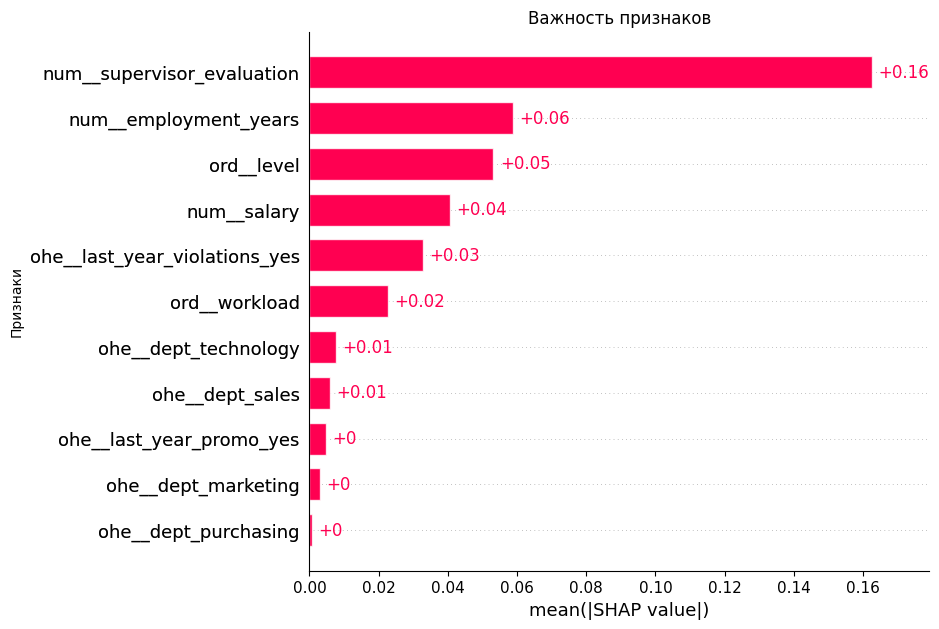

In [54]:
plt.title('Важность признаков')
plt.ylabel('Признаки')
shap.plots.bar(shap_values, max_display=17)

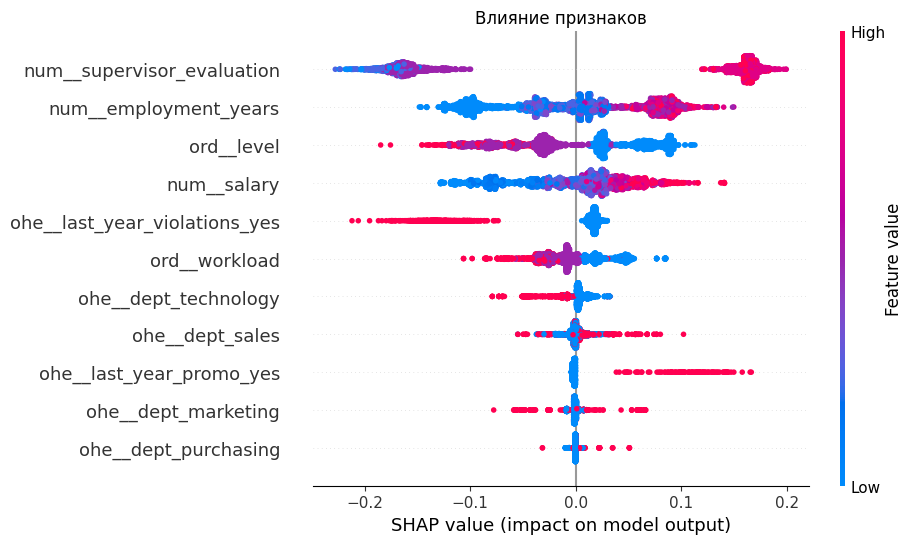

In [55]:
plt.title('Влияние признаков')
shap.plots.beeswarm(shap_values, max_display=17)

### Вывод

Лучше всего справилась модель **DecisionTreeRegressor**  с гиперпараметрами max_leaf_nodes=196, min_samples_split=8, random_state=42. Скорее всего это связано с нелинейной зависимости целевого признака, в этом случае линейная модель не нужна.Также как было указано выше в наших данных присутствует мультиколлинеарность, что негативно влияет на линейные модели.А модель **KNeighborsRegressor** тоже себя плохо показала, что может быть связан в плохой разделимости данных.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

## Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

### Загрузка данных

In [56]:
try:
    train_2 = pd.read_csv('train_quit.csv')
    test = pd.read_csv('test_features.csv')
    test_target_2 = pd.read_csv('test_target_quit.csv')
except:
    train_2 = pd.read_csv('/datasets/train_quit.csv')
    test = pd.read_csv('/datasets/test_features.csv')
    test_target_2 = pd.read_csv('/datasets/test_target_quit.csv')

Отсортируем по id тестовую выборку и целевой признак

In [57]:
test = pd.DataFrame(test.sort_values(by='id')).reset_index(drop=True)
test_target_2 = pd.DataFrame(test_target_2.sort_values(by='id').reset_index(drop=True))

### Предобработка данных

In [58]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [59]:
train_2.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [60]:
train_2.duplicated().sum()

0

In [61]:
for cl in train_2.select_dtypes(include='object').columns:
    print(f'{cl}: {train_2[cl].unique()}')

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']


### Вывод по предобработке данных

В тренировочных данных отстутсвуют пропуски и дубликаты 

### Исследовательский анализ данных

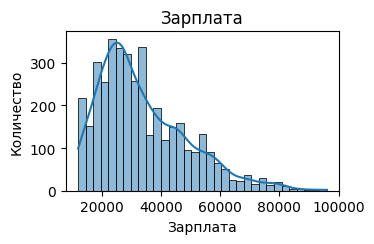

In [62]:
plt_num(train_2[['id','salary']])

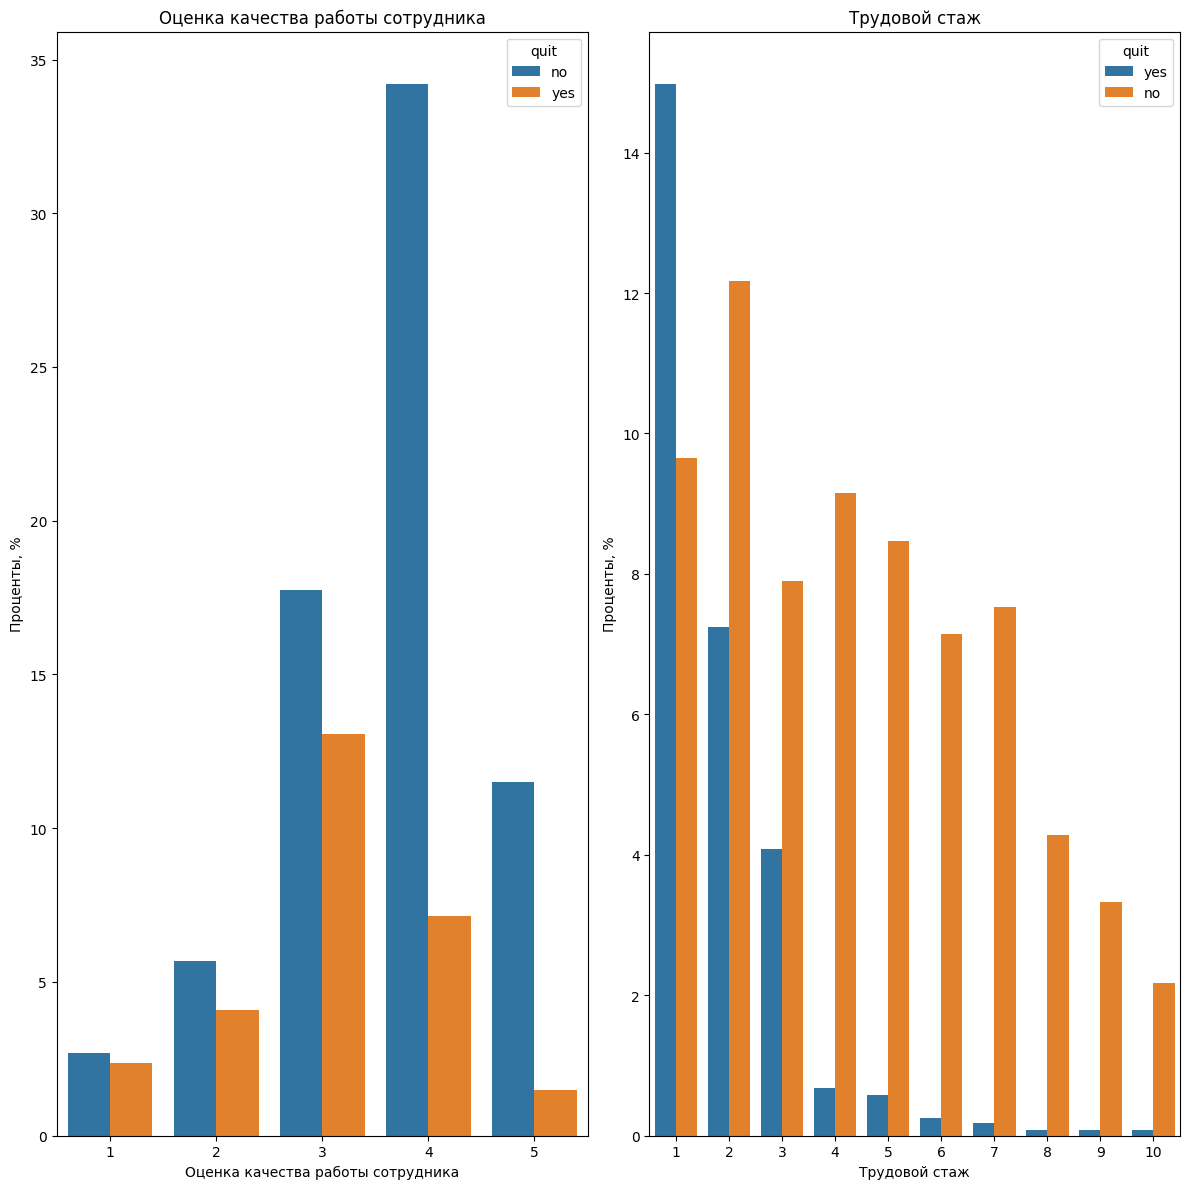

In [63]:
c = 1
for cl in ['supervisor_evaluation','employment_years']:
    plt.subplot(1,2,c)
    sns.countplot(data = train_2, x=cl, hue='quit', stat='percent')
    plt.title(f'{dictionary[cl]}')
    plt.xlabel(f'{dictionary[cl]}')
    plt.ylabel('Проценты, %')
    c += 1

plt.tight_layout()
plt.show()

Мы можем заметить, что больше всего людей увольняется с удовлетворительной оценкой качества работы от начальника. Также с увеличением трудового стажа работника в компании, количество увольнений уменьшается

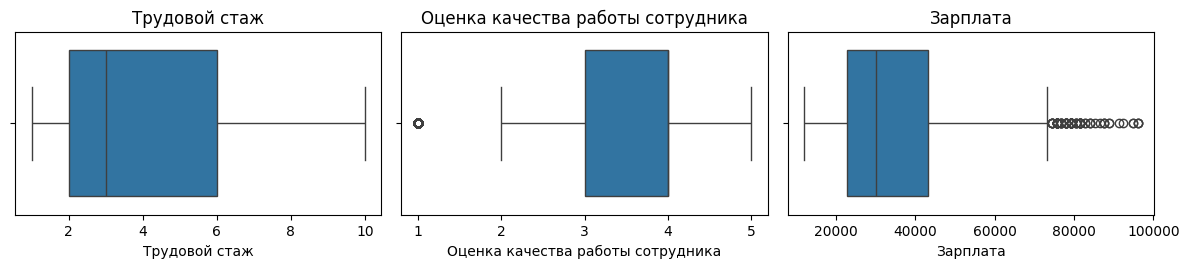

In [64]:
plt_num_boxplot(train_2)

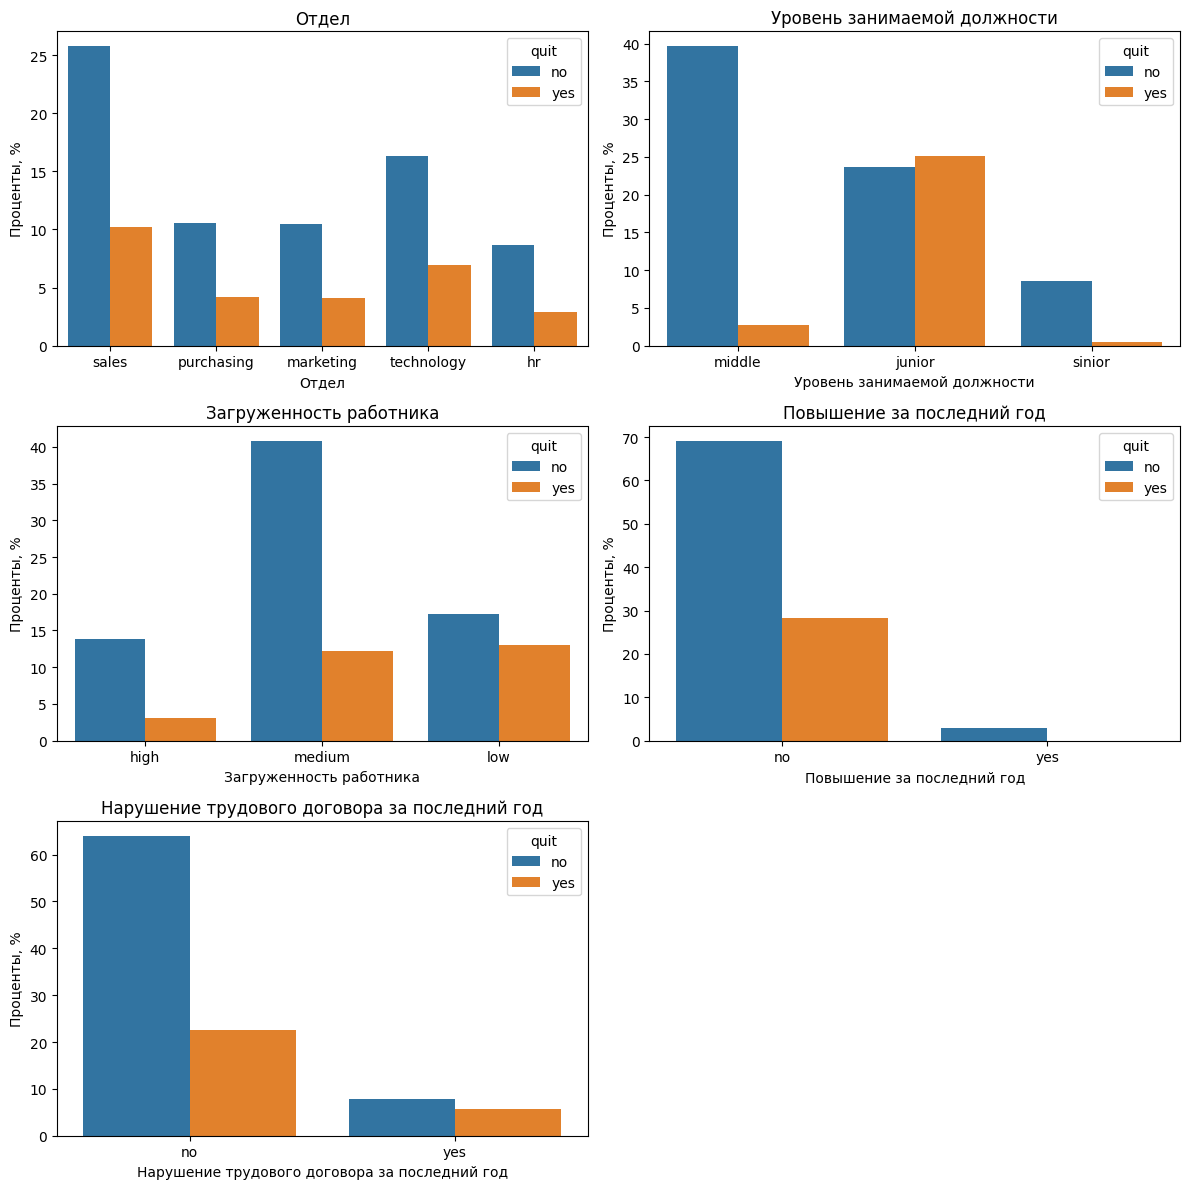

In [65]:
a = 3
b = 2
c = 1
for cl in train_2.drop('quit', axis=1).select_dtypes(include='object').columns:
    plt.subplot(a,b,c)
    sns.countplot(data = train_2, x=cl, hue='quit', stat='percent')
    plt.title(f'{dictionary[cl]}')
    plt.xlabel(f'{dictionary[cl]}')
    plt.ylabel('Проценты, %')
    c += 1

plt.tight_layout()
plt.show()

Увольняются больше всего работники,работающих в отделе продаж на клетке junior без повышения за последний год и без нарушений

In [66]:
train_2.groupby('quit').agg({'salary': ['median', 'std']})

salary              
       median           std
quit                       
no    34800.0  15218.977339
yes   22800.0   9351.599505

Зарплата людей, кто уволился меньше

### Вывод по исследовательскому анализу

Проанализировав графики можно сделать вывод, что уволившийся сотрудник это в большинстве случаев сотрудник продаж, находящийся на начальном уровне продаж, который немного поработал, имеющую удовлетворительную оценку от начальника с медианной зарплатой 22800, не получивший за последнйи год повышения

### Статистический анализ

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [67]:
df = test_target.merge(test_target_2)

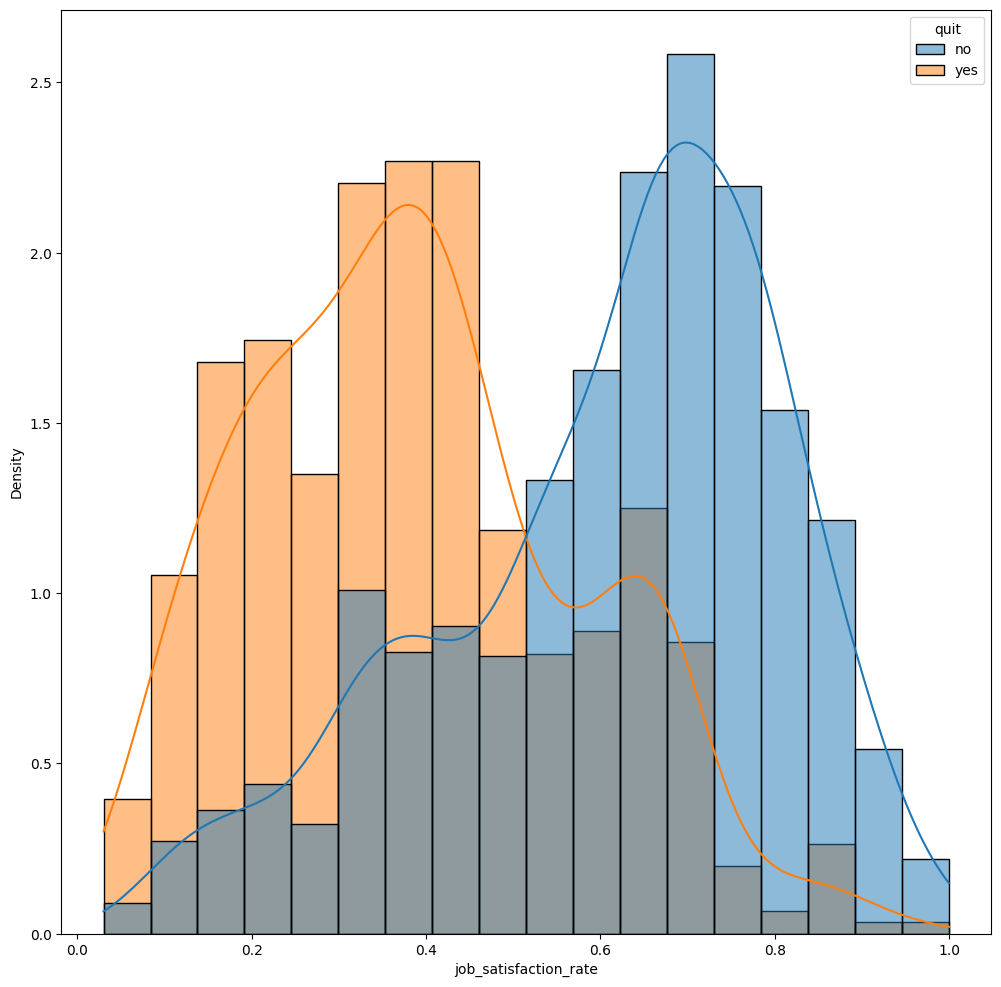

In [68]:
sns.histplot(data=df, x='job_satisfaction_rate', hue='quit', kde=True, stat='density', common_norm=False)
plt.show()

Проведем статистический тест о связанности увольнения и удовлетворреностью работой. Нулевой гипотезой будет гипотеза то, что среднее значение уровня удовлетворенности работника, который уволился равен уровню удовлетворенности, который не уволился. Альтернативной гипотезой будет служит нам неравенство средних значений выборок

In [69]:
p_value = ttest_ind(df.loc[df['quit'] == 'yes', 'job_satisfaction_rate'],\
                    df.loc[df['quit'] == 'no', 'job_satisfaction_rate'],\
                    equal_var=False, alternative='two-sided').pvalue

alpha = 0.05
if p_value > alpha:
    print('Принимаем нулевую гипотезу')

else:
    print('Отвергаем нулевую гипотезу')
    
print(p_value)

Отвергаем нулевую гипотезу
2.7708628031539e-101


Действительно мы можем предположить о связанности признаков

In [70]:
cat_col = train_2.select_dtypes(include='object').columns
num_col = train_2.select_dtypes(exclude='object').columns
vif(train_2, num_col, cat_col)

,Features,VIF
0,id,1.005821
1,employment_years,2.030296
2,supervisor_evaluation,1.173771
3,salary,9.536198
4,dept_marketing,1.841329
5,dept_purchasing,1.761364
6,dept_sales,2.757348
7,dept_technology,2.830431
8,level_middle,7.043347
9,level_sinior,5.418855


Сильная мультиколлинеарность отсутствует

### Добавление нового признака

получим новый признак 

In [71]:
job_satisfaction_rate = rnd.predict(train_2.drop('id', axis=1))

In [72]:
train_2['job_satisfaction_rate'] = job_satisfaction_rate

In [73]:
job_satisfaction_rate_test = rnd.predict(test.drop('id', axis=1))

In [74]:
test['job_satisfaction_rate'] = job_satisfaction_rate_test

In [75]:
X_1 = train_2.drop(['id', 'quit'], axis=1)
y_1 = train_2['quit']

In [76]:
lbl = LabelEncoder()

In [77]:
y_1 = lbl.fit_transform(y_1)

### Подготовка данных

In [78]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
num_col = X_train.select_dtypes(exclude='object').columns
ord_col = ['workload', 'level']

In [79]:
ohe_pipe = Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])


ord_pipe = Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan,\
                                       categories= [
                                           ['low', 'medium', 'high', ' '],
                                           ['junior','middle', 'sinior','nan']
                                       ])),
                ('impute_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [80]:
prep = ColumnTransformer([
                ('ohe', ohe_pipe, ohe_col),
                ('ord', ord_pipe, ord_col),       
                ('num', StandardScaler(), num_col)],
                remainder='passthrough'
                                    )

In [81]:
pipe_final = Pipeline([
                ('preprossesor', prep),
                ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [82]:
param_distribution = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,100),
        'preprossesor__num':[StandardScaler(), RobustScaler(), Normalizer()]
        
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprossesor__ohe':[OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), OrdinalEncoder(handle_unknown='use_encoded_value')],
        'preprossesor__num':[StandardScaler(), RobustScaler(), Normalizer()],
        'models__max_depth': range(2,7),
        'models__min_samples_split': range(2,200),
        'models__min_samples_leaf': range(2,200)
    }
]

### Обучение модели

In [83]:
y_test = lbl.transform(test_target_2['quit'])

In [84]:
dummy_classifier = DummyClassifier(random_state=RANDOM_STATE)
dummy_classifier.fit(X_1, y_1)
y_pred = dummy_classifier.predict_proba(test)[:,1]

In [85]:
roc_auc_score(y_test, y_pred)

0.5

In [86]:
rnd_2 = RandomizedSearchCV(pipe_final, param_distributions=param_distribution, cv=5, n_jobs=-1, n_iter=300, scoring='roc_auc')

In [87]:
rnd_2.fit(X_1, y_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprossesor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imp...
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 7),
                                         'models__min_samples_leaf': range(2, 200),
                                         'models__min_samples_split': range(2, 200),
                                         'preprossesor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               Normalizer()],
                                         'preprossesor__ohe': [OneHotEncoder(drop='first',
                                                                             handle_unknown='ignore',
                                                                             sparse=False),
                                                               OrdinalEncoder(handle_unknown='use_encoded_value')]}],
                   scoring='roc_auc')

In [88]:
rnd_2.best_estimator_

Pipeline(steps=[('preprossesor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               ' '],
                                                                                              ['ju...
                                                                                               'nan']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', StandardScaler(),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object'))])),
                ('models',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=9,
                                        min_samples_split=117,
                                        random_state=42))])

In [89]:
rnd_2.best_score_

0.929018945706656

In [90]:
result = pd.DataFrame(rnd_2.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
171,1,DecisionTreeClassifier(random_state=42),0.929019,{'preprossesor__ohe': OneHotEncoder(drop='firs...
76,2,DecisionTreeClassifier(random_state=42),0.928949,{'preprossesor__ohe': OneHotEncoder(drop='firs...
243,3,DecisionTreeClassifier(random_state=42),0.928235,{'preprossesor__ohe': OneHotEncoder(drop='firs...
235,4,DecisionTreeClassifier(random_state=42),0.928094,{'preprossesor__ohe': OneHotEncoder(drop='firs...
96,5,DecisionTreeClassifier(random_state=42),0.927639,{'preprossesor__ohe': OneHotEncoder(drop='firs...


In [91]:
ohe = rnd_2.best_estimator_['preprossesor']

In [92]:
X_1 = pd.DataFrame(ohe.fit_transform(X_1), columns=ohe.get_feature_names_out())

In [93]:
best_model = rnd_2.best_estimator_['models'].fit(X_1, y_1)

In [94]:
explainer = shap.TreeExplainer(best_model, X_1)
shap_values = explainer(X_1)

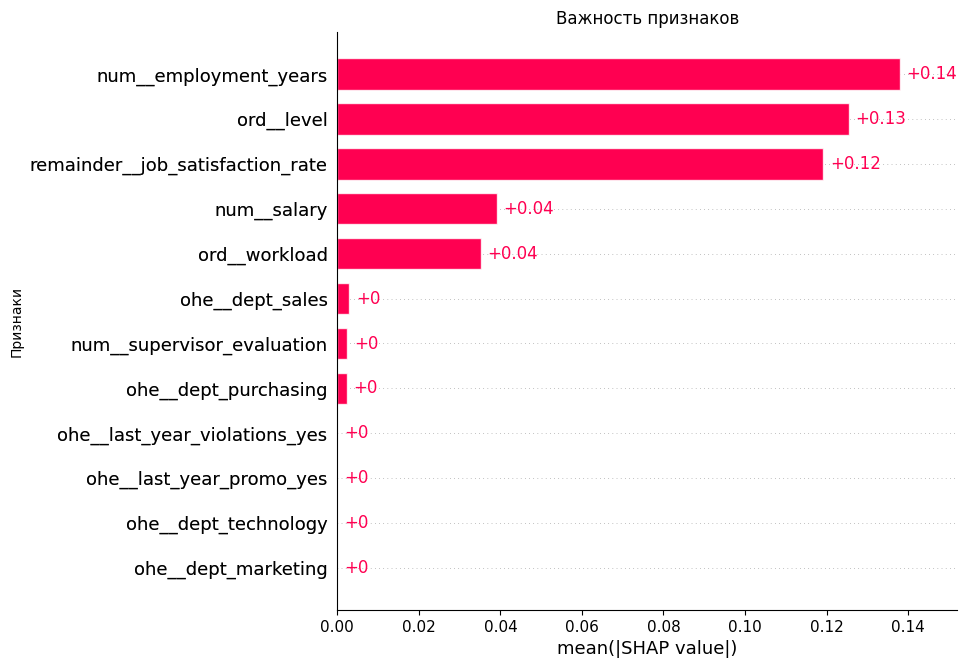

In [95]:
plt.title('Важность признаков')
plt.ylabel('Признаки')
shap.plots.bar(shap_values[:,:,1], max_display=17)

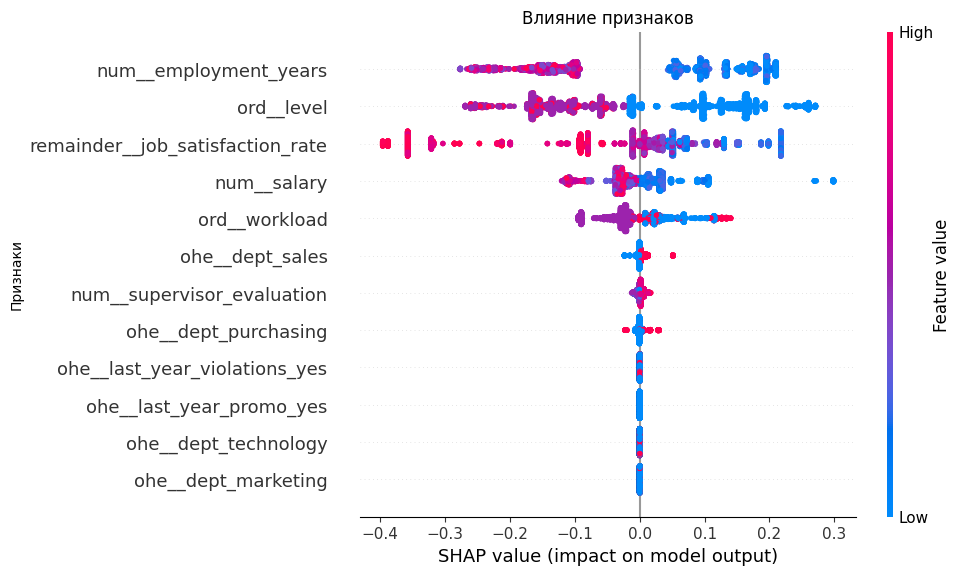

In [96]:
plt.title('Влияние признаков')
plt.ylabel('Признаки')
shap.plots.beeswarm(shap_values[:,:,1], max_display=17)

Можем заметить, что признаки **last_year_violations, last_year_promo, dept** для модели являются неважными, поэтому удалим их

In [97]:
X_1 = train_2.drop(['id', 'quit', 'last_year_violations', 'last_year_promo', 'dept'], axis=1)
y_1 = train_2['quit']

In [98]:
lbl = LabelEncoder()

In [99]:
y_1 = lbl.fit_transform(y_1)

In [100]:
num_col = X_train.select_dtypes(exclude='object').columns
ord_col = ['workload', 'level']

In [101]:
ord_pipe = Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan,\
                                       categories= [
                                           ['low', 'medium', 'high', ' '],
                                           ['junior','middle', 'sinior','nan']
                                       ])),
                ('impute_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [102]:
prep = ColumnTransformer([
                ('ord', ord_pipe, ord_col),       
                ('num', StandardScaler(), num_col)],
                remainder='passthrough'
                                    )

In [103]:
pipe_final = Pipeline([
                ('preprossesor', prep),
                ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [104]:
param_distribution = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,100),
        'preprossesor__num':[StandardScaler(), RobustScaler(), Normalizer()]
        
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprossesor__num':[StandardScaler(), RobustScaler(), Normalizer()],
        'models__max_depth': range(2,7),
        'models__min_samples_split': range(2,200),
        'models__min_samples_leaf': range(2,200)
    }
]

In [105]:
rnd_3 = RandomizedSearchCV(pipe_final, param_distributions=param_distribution, cv=5, n_jobs=-1, n_iter=300, scoring='roc_auc')

In [106]:
%%time
rnd_3.fit(X_1, y_1)

CPU times: total: 3.16 s
Wall time: 9.96 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprossesor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['low',
                                                                                                                            'medium',
                                                                                                                            'high',
                                                                                                                            ' '],
                                                                                                                           ['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior',
                                                                                                                            'nan']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('...
                                         'preprossesor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               Normalizer()]},
                                        {'models': [LogisticRegression(random_state=42)]},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 7),
                                         'models__min_samples_leaf': range(2, 200),
                                         'models__min_samples_split': range(2, 200),
                                         'preprossesor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               Normalizer()]}],
                   scoring='roc_auc')

In [107]:
rnd_3.best_estimator_

Pipeline(steps=[('preprossesor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               ' '],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'sinior',
                                                                                               'nan']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', RobustScaler(),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object'))])),
                ('models',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=29,
                                        min_samples_split=107,
                                        random_state=42))])

In [108]:
rnd_3.best_score_

0.9299007724195419

Метрика немного улучшилась

In [109]:
y_pred = rnd_3.best_estimator_.predict_proba(test.drop('id', axis=1))[:,1]

In [110]:
roc_auc_score(y_test, y_pred)

0.9208109850056302

### Вывод

Во второй задаче расмматривались модели **LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier**. Лучше всего справилась с задачей дерево решений с гиперапарметрами **max_depth=6, min_samples_leaf=22, min_samples_split=42**. Скорее всего это связано с тем, что в задаче присутствует нелинейная связь целевого признака с предиктором

## Общий вывод

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от **0 до 1**, где **0 — совершенно неудовлетворён, 1 — полностью удовлетворён**. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
- **Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- **Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


1. В первой задаче
   - Предобработка данных показала, что в данных отстуствуют явные и неявные дубликаты. Также присутствует небольшое количество пропусков
   - Зарплата сотрудников имеет длинный правый хвост, а уровень удовлетворенности работой имеет два выраженных пика.
   - В компании почти половина сотрудников работает до двух лет в этой компании. Оценка работника руководителем в основном 3 либо 4.В компании больше всего работают в продажах, уровня middle, junior, со средним уровнем загруженности, без повышения в зарплате за последний год и без нарушений.
   - Работники у которых за последний год были нарушения имеют медианное значение удовлетворенности работой намного ниже, чем те кто не совершал.
   - Лучше всего справилась модель **DecisionTreeRegressor**  с гиперпараметрами **max_leaf_nodes=196, min_samples_split=8**. Скорее всего это связано с нелинейной зависимости целевого признака, в этом случае линейная модель не нужна. А модель **KNeighborsRegressor** тоже себя плохо показала, что может быть связан в плохой разделимости данных.

2. Во второй задаче:
 - В тренировочных данных отстутсвуют пропуски и дубликаты
 - Проанализировав графики можно сделать вывод, что уволившийся сотрудник это в большинстве случаев сотрудник продаж, находящийся на начальном уровне продаж, который немного поработал, имеющую удовлетворительную оценку от начальника с медианной зарплатой 22800, не получивший за последнйи год повышения
 - Действительно мы можем предположить о связанности признаков `job_satisfaction_rate` и `quit`
 - Лучше всего справилась с задачей дерево решений с гиперапарметрами **max_depth=6,min_samples_leaf=22, min_samples_split=42, random_state=42**. Скорее всего это связано с тем, что в задаче присутствует нелинейная связь целевого признака с предиктором


На уровень удовлетворенности работой больше всего влияет оценка руководителя. Больше похвалы стимулирует работника лучше работать, что в свою очередь уменьшает вероятность увольнения работника. Также чем больше работник работает в компании, тем вероятнее он и останется работать в этой компании. Также с повышением зарплаты риск ухода из компании уменьшается. Также имеет место загруженность работников, следует внимательно следить за нагрузкой подчиненных и по возможности балансировать между всеми.В первую очередь следует обратить внимание на работников с маленьким стажем и работающих на должности junior. Для них, как пример, может помочь наставничество, со средней нагрузкой и положительными отзывами от руководителя.